In [54]:
#Mini Project - Heart Disease UCI Dataset
import pandas as pd

from google.colab import files #access the “Heart Disease UCI” dataset.
uploaded = files.upload()

df = pd.read_csv("heart_disease_uci.csv")


df.head() #Take a quick look
print(df.head()) #perform initial data analysis
print(df.info())
print(df.describe())
print(df.dtypes)

Saving heart_disease_uci.csv to heart_disease_uci (6).csv
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3     

##Initial Analysis:
###There are 920 records with 16 features including numerical (integer, float) and categorical (object). Slope, CA, thal have the greatest number of missing values. num seems to indicate the level of heart disease (from 0 to 4).

In [55]:
#Task 1: Data Preparation

#Perform exploratory data analysis (EDA) to understand the dataset.

print(df.isnull().sum())

df = df.fillna(0) #handle missing values (had issues with NaN after initial clean up)

print("Any NaN left in df?", df.isnull().any().any())

num_col = df.select_dtypes(include=["int64", "float64"]).columns #categorize numeric columns
cat_col = df.select_dtypes(include=["object"]).columns #categorize categorical columns

  ## mo longer going with this method due to NaN issues
  #df[num_col] = df[num_col].fillna(df[num_col].median())

  #for col in cat_col:
      #df[col] = df[col].fillna(df[col].mode()[0])

df.drop(columns=['ca', 'thal', 'dataset', 'exang'], inplace=True, errors='ignore') #drop the columns with the most null values

df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}) #binary conversion

df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope'], drop_first=True) #one hot encode

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64
Any NaN left in df? False


In [56]:
#as 'num' is the target feature, and we're using a logistic regression model, I will group 1 - 4 into one batch and 0 in the other.

df['num'].unique() #confirmation

df['num'] = df['num'].replace({1: 1, 2: 1, 3: 1, 4: 1})

results = {0: 'No Heart Disease', 1: 'Has Heart Disease'}
print(df['num'].value_counts().rename(index=results))

num
Has Heart Disease    509
No Heart Disease     411
Name: count, dtype: int64


In [57]:
from sklearn.model_selection import train_test_split
#Model Training:

y = df['num']
X = df.drop('num', axis=1) #remove target column

X_train = X_train.dropna()
X_test = X_test.dropna()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
) #Split the dataset into a training set and a testing set.

print(X_train.shape, X_test.shape)

(736, 17) (184, 17)


#Training data comprises 736 records, while test set is 184.

In [58]:
import numpy as np
from sklearn.preprocessing import StandardScaler
#scale features

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#Train a logistic regression model on the training set.

In [62]:
from sklearn.linear_model import LogisticRegression

#train the model
model = LogisticRegression(max_iter=10000) #updated iterations

model.fit(X_train, y_train.values.ravel())

pred = model.predict(X_test)

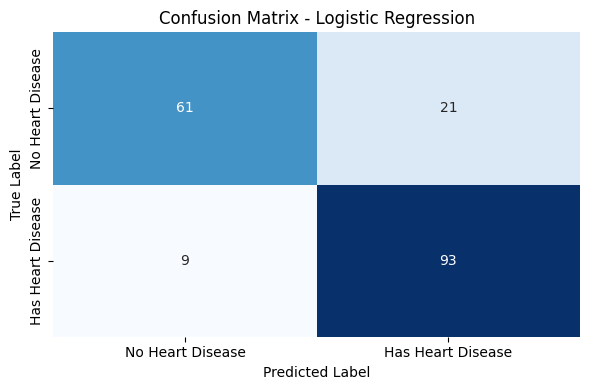

Accuracy: 0.8369565217391305
Confusion Matrix:
 [[61 21]
 [ 9 93]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.74      0.80        82
           1       0.82      0.91      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



In [65]:
#Task 3 - Model Evaluation

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['No Heart Disease', 'Has Heart Disease']
cm = confusion_matrix(y_test, pred)

# Create DataFrame for easier labeling
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


print("Accuracy:", accuracy_score(y_test, pred)) #model evaluation - accuracy
print("Confusion Matrix:\n", confusion_matrix(y_test, pred)) #confusion matrix
print("Classification Report:\n", classification_report(y_test, pred))

#Model Evaluation:
##The logistic regression model achieved overall accuracy of 83.7%, correctly identifying 61 patients without heart disease (True Positive) and 93 with heart disease (True Negative). It erroneously predicted 21 healthy cases with heart disease and 9 patients with heart disease as healthy. Some misclassification may be because I grouped heart disease severity levels (1 - 4) into a single “disease” class, which can reduce nuance in predictions. Overall, the model performs well for a simple logistic regression baseline.

##The model demonstrates a solid balance between precision (0.82–0.87) and recall (0.74–0.91) across both classes, resulting in strong F1 scores (0.80 and 0.86).
